**What is the sentiment of the verses of the crosswalks in Madrid using [robertuito-sentiment-analysis](https://huggingface.co/pysentimiento/robertuito-sentiment-analysis)?**

Model trained with TASS 2020 corpus (around ~5k tweets) of several dialects of Spanish. Base model is [RoBERTuito](https://github.com/pysentimiento/robertuito), a RoBERTa model trained in Spanish tweets.

**Setup**

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install pysentimiento

In [ ]:
!pip install matplotlib

In [ ]:
!pip install pandas

**Usage**

Using the model directly with [pysentimiento](https://github.com/finiteautomata/pysentimiento/)[^1]

[^1]: Juan Manuel Pérez and Juan Carlos Giudici and Franco Luque. **pysentimiento**: A Python Toolkit for Sentiment Analysis and SocialNLP tasks [Internet]. arXiv; 2011. Available from: https://arxiv.org/abs/2106.09462


In [7]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="es")

analyzer.predict("Qué gran jugador es Messi")

AnalyzerOutput(output=POS, probas={POS: 0.946, NEU: 0.037, NEG: 0.017})

In [8]:
analyzer.predict("Esto es pésimo")

AnalyzerOutput(output=NEG, probas={NEG: 0.887, NEU: 0.098, POS: 0.014})

**On the basis of the results of the OpenAI**

In [9]:
import pandas as pd

versos_al_paso_geo_file_path = './output/versosalpaso_sentiment_text-davinci-003_geo.csv'
versos_al_paso_spanish_sentiment = pd.read_csv(versos_al_paso_geo_file_path, sep=';', encoding='utf-8')
versos_al_paso_spanish_sentiment.columns

Index(['Unnamed: 0', 'id', 'latitud', 'longitud', 'autor', 'barrio', 'verso',
       'direccion', 'sentiment', 'quarter', 'district', 'city'],
      dtype='object')

**Rename the column** for the associated sentiment using OpenAI

In [10]:
versos_al_paso_spanish_sentiment.columns = ['Unnamed: 0', 'id', 'latitud', 'longitud', 'autor', 'barrio', 'verso', 'direccion', 
                                            'openai_sentiment',
                                            'quarter', 'district', 'city']
versos_al_paso_spanish_sentiment.columns

Index(['Unnamed: 0', 'id', 'latitud', 'longitud', 'autor', 'barrio', 'verso',
       'direccion', 'openai_sentiment', 'quarter', 'district', 'city'],
      dtype='object')

In [11]:
versos_al_paso_spanish_sentiment[0:1]

,Unnamed: 0,id,latitud,longitud,autor,barrio,verso,direccion,openai_sentiment,quarter,district,city
0,0,1000,40.425239,-3.691217,﻿Mario Vaillo de Mingo,﻿CENTRO,Quizá el secreto de la vida tan solo consista ...,﻿Calle de Génova-Plaza Colón,positive,Justicia,Centro,Madrid


**Adding** results

In [12]:
robertuito_sentiment_analysis = pd.DataFrame(versos_al_paso_spanish_sentiment.verso)
robertuito_sentiment_analysis['robertuito_sentiment'] = ''
robertuito_sentiment_analysis['robertuito_sentiment_probas'] = ''

robertuito_sentiment_analysis[0:1]

,verso,robertuito_sentiment,robertuito_sentiment_probas
0,Quizá el secreto de la vida tan solo consista ...,,


In [14]:
import json
import math

def get_sentiment(sentiment_result) -> str:
    sentiment_labels = { 'NEG': 'negative', 'NEU': 'neutral', 'POS': 'positive' }
    
    sentiment = sentiment_result.output
    sentiment_probas = sentiment_result.probas

    if sentiment == 'NEG' and \
        (sentiment_probas['NEG'] < sentiment_probas['NEU'] + sentiment_probas['POS'] or \
        math.isclose(0.5, sentiment_probas['NEG'], abs_tol = 1e-2)):
            sentiment = 'NEU'

    return sentiment_labels[sentiment]

for i, row in robertuito_sentiment_analysis.iterrows():
    verse = row.verso
    print(i, end='\r')

    res = analyzer.predict(verse)
    robertuito_sentiment_analysis.at[i, 'robertuito_sentiment'] = get_sentiment(res)
    robertuito_sentiment_analysis.at[i, 'robertuito_sentiment_probas'] = json.dumps(res.probas)


In [15]:
robertuito_sentiment_analysis[0:1]

,verso,robertuito_sentiment,robertuito_sentiment_probas
0,Quizá el secreto de la vida tan solo consista ...,positive,"{""NEG"": 0.028908291831612587, ""NEU"": 0.4850387..."


Saving it

In [16]:
versos_al_paso_spanish_sentiment['robertuito_sentiment'] = robertuito_sentiment_analysis.robertuito_sentiment
versos_al_paso_spanish_sentiment['robertuito_sentiment_probas'] = robertuito_sentiment_analysis.robertuito_sentiment_probas

In [17]:
versos_al_paso_spanish_sentiment[0:1]

,Unnamed: 0,id,latitud,longitud,autor,barrio,verso,direccion,openai_sentiment,quarter,district,city,robertuito_sentiment,robertuito_sentiment_probas
0,0,1000,40.425239,-3.691217,﻿Mario Vaillo de Mingo,﻿CENTRO,Quizá el secreto de la vida tan solo consista ...,﻿Calle de Génova-Plaza Colón,positive,Justicia,Centro,Madrid,positive,"{""NEG"": 0.028908291831612587, ""NEU"": 0.4850387..."


In [18]:
versos_al_paso_spanish_sentiment_file_path = './output/versosalpaso_robertuito-sentiment-analysis.csv'
versos_al_paso_spanish_sentiment.to_csv(versos_al_paso_spanish_sentiment_file_path, sep=';', encoding='utf-8')

**A pie chart for sentiment values**

In [19]:
df = versos_al_paso_spanish_sentiment.groupby(['robertuito_sentiment'])['robertuito_sentiment'].count()
df

robertuito_sentiment
negative    277
neutral     637
positive    186
Name: robertuito_sentiment, dtype: int64

<Axes: title={'center': 'Sentiments'}>

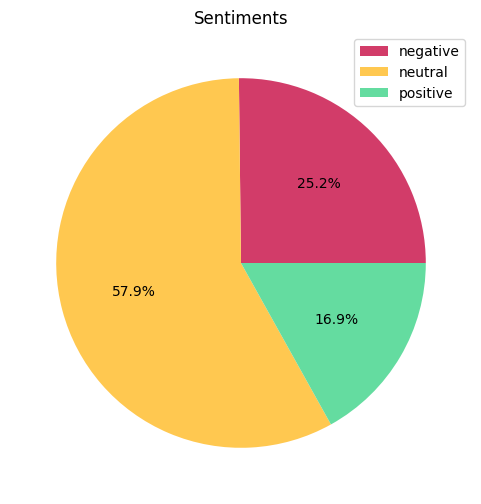

In [20]:
colors = ['#D23C69','#FFC850','#64DCA0']
df.plot.pie(legend=True, title='Sentiments', autopct='%1.1f%%', colors=colors, ylabel='', labeldistance=None, figsize=(6, 6))

**A horizontal bar chart by district**

In [21]:
table_by_barrio = pd.pivot_table(versos_al_paso_spanish_sentiment[['district', 'robertuito_sentiment']], index='district', columns='robertuito_sentiment', aggfunc=len, fill_value=0)
table_by_barrio

robertuito_sentiment,negative,neutral,positive
district,,,
Arganzuela,12,30,11
Barajas,3,5,3
Carabanchel,20,49,12
Centro,16,38,16
Chamartín,21,36,18
Chamberí,20,36,8
Ciudad Lineal,22,47,9
Fuencarral-El Pardo,12,43,10
Hortaleza,11,35,10


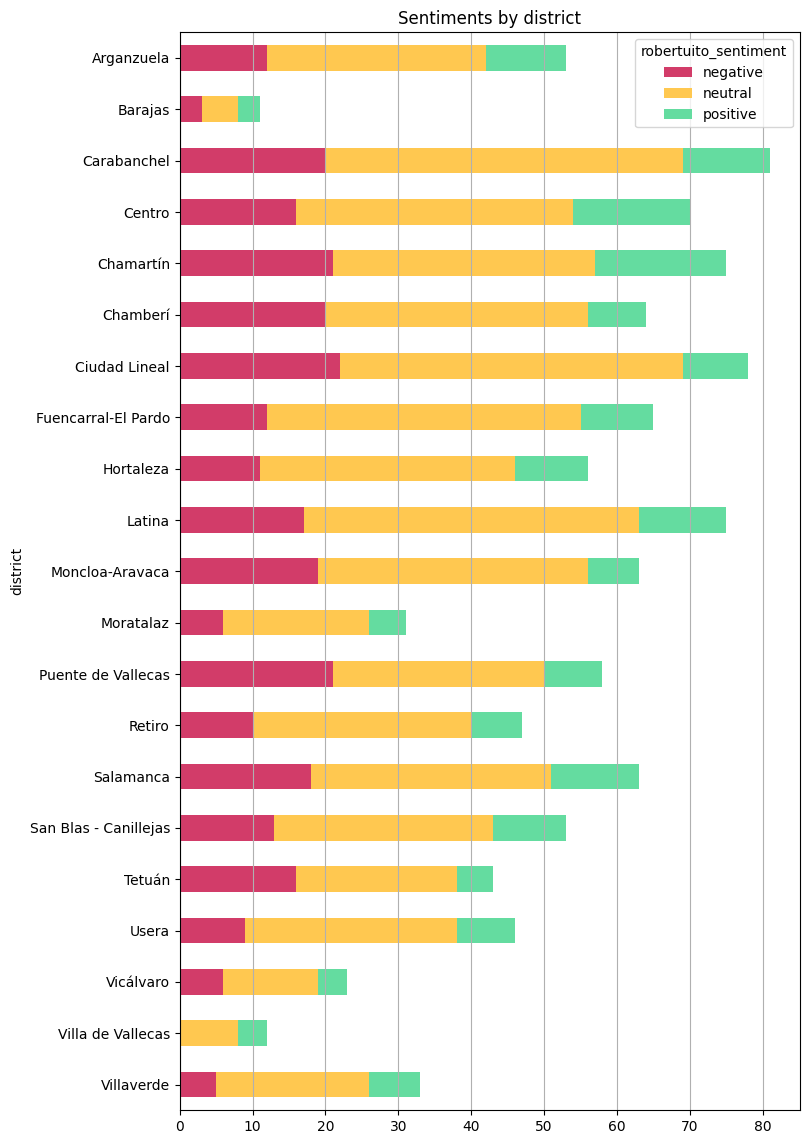

In [22]:
import matplotlib.pyplot as plt

colors = {'negative': '#D23C69', 'neutral': '#FFC850', 'positive': '#64DCA0'}
ax = table_by_barrio.plot.barh(color=colors, title='Sentiments by district', figsize=(8, 14), grid=True, stacked=True)
ax.invert_yaxis()
ax.grid(axis='y')

**Show all rows and full column content**

In [23]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

**Taking a look** to the verses

**OpenAI vs. library**

In [28]:
openai_says_negative = versos_al_paso_spanish_sentiment[versos_al_paso_spanish_sentiment.openai_sentiment.eq('negative')]
openai_diffs = openai_says_negative[openai_says_negative.robertuito_sentiment != 'negative']
openai_diffs[['district', 'verso', 'openai_sentiment', 'robertuito_sentiment', 'robertuito_sentiment_probas']]

,district,verso,openai_sentiment,robertuito_sentiment,robertuito_sentiment_probas
110,Salamanca,"No hay nada más bello que lo que nunca he tenido, nada más amado que lo que perdí.",negative,neutral,"{""NEG"": 0.24424991011619568, ""NEU"": 0.4472581744194031, ""POS"": 0.308491975069046}"
112,Arganzuela,Quizás lo que nos salva son los raros momentos en que no pasa nada.,negative,neutral,"{""NEG"": 0.09175972640514374, ""NEU"": 0.5002381205558777, ""POS"": 0.40800216794013977}"
419,Villa de Vallecas,Lanzaré a tu noche oscura los dados de mis dudas,negative,neutral,"{""NEG"": 0.3424125015735626, ""NEU"": 0.5610204935073853, ""POS"": 0.0965670794248581}"
433,Fuencarral-El Pardo,En vez de pájaro en mano prefiero una gran desbandada en la cabeza,negative,neutral,"{""NEG"": 0.2821086049079895, ""NEU"": 0.6785085201263428, ""POS"": 0.03938284516334534}"
602,Carabanchel,Cuídate del recuerdo.,negative,neutral,"{""NEG"": 0.17033535242080688, ""NEU"": 0.4965837299823761, ""POS"": 0.3330810070037842}"
904,Fuencarral-El Pardo,Pecas. En todas sus acepciones.,negative,neutral,"{""NEG"": 0.07449241727590561, ""NEU"": 0.4765632450580597, ""POS"": 0.4489443898200989}"


**Library vs. OpenAI**

In [24]:
def lib_vs_openai(sentiment: str) -> pd.DataFrame:
    lib_says = versos_al_paso_spanish_sentiment[versos_al_paso_spanish_sentiment.robertuito_sentiment.eq(sentiment)]
    return lib_says[['district', 'verso', 'robertuito_sentiment', 'openai_sentiment', 'robertuito_sentiment_probas']]

In [25]:
looks_like_negative = lib_vs_openai('negative')

In [26]:
looks_like_negative[looks_like_negative.openai_sentiment.eq('negative')].sort_values('district')

,district,verso,robertuito_sentiment,openai_sentiment,robertuito_sentiment_probas
600,Carabanchel,Si el monstruo te da miedo ¿Por Qué le das de comer?,negative,negative,"{""NEG"": 0.8422860503196716, ""NEU"": 0.1420147866010666, ""POS"": 0.015699122101068497}"
104,Centro,La tristeza es vulgar si no es inmensa y esconde muchas veces un placer venenoso,negative,negative,"{""NEG"": 0.8713924884796143, ""NEU"": 0.10869462788105011, ""POS"": 0.019912881776690483}"
270,Chamberí,- El sermón del predicador es la oración del necio,negative,negative,"{""NEG"": 0.5522733926773071, ""NEU"": 0.3926156163215637, ""POS"": 0.05511101335287094}"
174,Latina,Madrid me duele.,negative,negative,"{""NEG"": 0.9383610486984253, ""NEU"": 0.04956323280930519, ""POS"": 0.012075752019882202}"
89,Moncloa-Aravaca,Nadie es un candidato tan popular para el agravio como una víctima,negative,negative,"{""NEG"": 0.8906323909759521, ""NEU"": 0.09537317603826523, ""POS"": 0.01399452704936266}"
504,Moncloa-Aravaca,Algo está roto si el odio une tanto.,negative,negative,"{""NEG"": 0.9186822772026062, ""NEU"": 0.07271198183298111, ""POS"": 0.00860571675002575}"
790,Moncloa-Aravaca,O me paras los pies o esto se me va de las manos.,negative,negative,"{""NEG"": 0.9488758444786072, ""NEU"": 0.04295216128230095, ""POS"": 0.008172034285962582}"
14,Retiro,"Peladitos ven TV y quieren ser así, están aprendiendo a matar antes que a vivir",negative,negative,"{""NEG"": 0.8632475137710571, ""NEU"": 0.12270446121692657, ""POS"": 0.014047921635210514}"
500,San Blas - Canillejas,Te pido perdón por el daño que me hiciste.,negative,negative,"{""NEG"": 0.8238727450370789, ""NEU"": 0.13378791511058807, ""POS"": 0.04233936965465546}"
8,Tetuán,La política tiene colgado el cartel de rebajas,negative,negative,"{""NEG"": 0.7827954888343811, ""NEU"": 0.20046870410442352, ""POS"": 0.01673584245145321}"


In [138]:
looks_like_negative[looks_like_negative.openai_sentiment != 'negative'].sort_values('district')

,district,verso,robertuito_sentiment,openai_sentiment,robertuito_sentiment_probas
571,Arganzuela,Vivir es un trabajo que al final siempre está mal pagado,negative,positive,"{""NEG"": 0.9438312649726868, ""NEU"": 0.051258623600006104, ""POS"": 0.004910130053758621}"
576,Arganzuela,Si me voy has de saber que no salvé los muebles de tus llamas,negative,positive,"{""NEG"": 0.775747537612915, ""NEU"": 0.20140603184700012, ""POS"": 0.022846456617116928}"
412,Arganzuela,Me despeinas las ideas,negative,positive,"{""NEG"": 0.763863742351532, ""NEU"": 0.15712003409862518, ""POS"": 0.07901615649461746}"
837,Arganzuela,En pleno centro el olor de la hierba recién cortada.,negative,positive,"{""NEG"": 0.7184529900550842, ""NEU"": 0.23105694353580475, ""POS"": 0.05049009993672371}"
965,Arganzuela,"-Me dijiste que te irías, pero llevas en mi casa toda la vida.",negative,positive,"{""NEG"": 0.8837698101997375, ""NEU"": 0.09898547828197479, ""POS"": 0.017244694754481316}"
411,Arganzuela,Seguís mirando relojes que nunca han dado la hora,negative,positive,"{""NEG"": 0.8024016618728638, ""NEU"": 0.18386846780776978, ""POS"": 0.013729862868785858}"
933,Arganzuela,Voy a hacerte feliz. Sufrirá tanto que le pondrás mi nombre a la tristeza,negative,positive,"{""NEG"": 0.5459563136100769, ""NEU"": 0.3786053955554962, ""POS"": 0.07543829083442688}"
728,Arganzuela,Mancho la tierra con la semilla última de la esperanza.,negative,positive,"{""NEG"": 0.6859742999076843, ""NEU"": 0.26610875129699707, ""POS"": 0.04791697859764099}"
727,Arganzuela,Me duele la vida donde a otros les late el corazón.,negative,positive,"{""NEG"": 0.935833215713501, ""NEU"": 0.05716406926512718, ""POS"": 0.007002735510468483}"
207,Arganzuela,De la humillación del poeta nace la poesía,negative,positive,"{""NEG"": 0.6141642332077026, ""NEU"": 0.31842583417892456, ""POS"": 0.06740991771221161}"
